#TF - Term Frequency(removed for each row against each document) 
    - Occurance of word in a document / no. of words in that document

#IDF - Inverse Document Frequency
     - Number documents * TF

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re 
from functools import reduce

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/codeforces-code/dump-tokenized.jsonl.gz
/kaggle/input/codeforces-code/dump-original.jsonl.gz
/kaggle/input/codeforces-code/dump-original.jsonl/dump-original.jsonl
/kaggle/input/codeforces-code/dump-tokenized.jsonl/dump-tokenized.jsonl


In [2]:
#### Converting the data into DataFrame ####

with open('../input/codeforces-code/dump-original.jsonl/dump-original.jsonl') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
df = pd.DataFrame(data)

df['language_id'] = df['language'].factorize()[0]

df.head(5)
#df.language.value_counts() #source count per language
lang_list = list(set(df['language'].tolist())) #list of languages

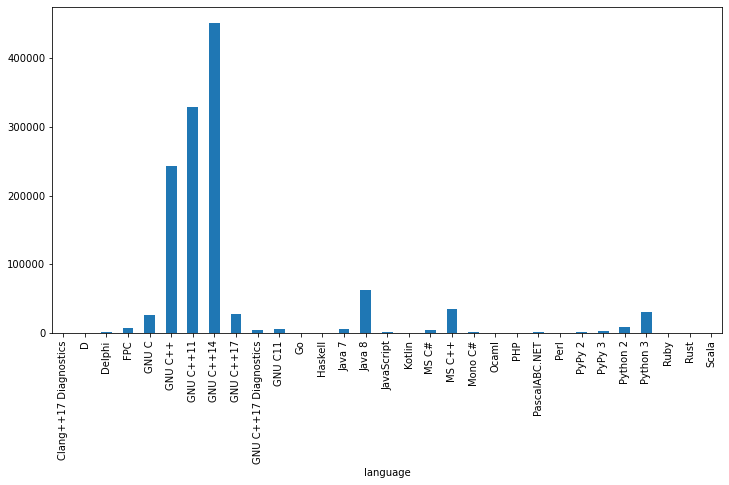

In [3]:
#### Plotting number of sources per language ####

fig = plt.figure(figsize=(12,6))
df.groupby('language').source.count().plot.bar(ylim=0)
plt.show()

In [4]:
#### Trial for 1 language ####

#preprocess
def preprocess_text(sentence):
    # Remove punctuations and numbers
    #sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\b[a-zA-Z]\b", "", sentence)
    # Removing special char
    sentence = re.sub(r'[^a-zA-Z0-9_\s]+', '', sentence)
    #remove digits
    sentence = re.sub(" \d+", " ", sentence)
    #remove multiple spaces
    sentence = re.sub(" \s+", " ", sentence)
    return sentence

def countIn_corpus(str_list):
    ctr = Counter(chain.from_iterable(map(lambda x:preprocess_text(x).split(),str_list)))
    return ctr

for lang in lang_list:
    if lang == 'GNU C++':
       lang_df = df.loc[df['language'] == lang]
       lang_corpus = lang_df['source'].tolist()
       #freq 50
       counts_lang_corpus_dict = dict(countIn_corpus(lang_corpus))
       freq_words_lang_corpus = sorted(counts_lang_corpus_dict, key=counts_lang_corpus_dict.get,reverse = True)

In [5]:
#### Feature Extraction ####

#preprocess
def preprocess_text(sentence):
    sentence = re.sub(r"\b[a-zA-Z]\b", "", sentence)# Single character removal
    sentence = re.sub(r'[^a-zA-Z0-9_\s]+', '', sentence)# Removing special char
    sentence = re.sub(" \d+", " ", sentence)#remove digits
    sentence = re.sub(" \s+", " ", sentence)#remove multiple spaces
    return sentence

#count every token
def countIn_corpus(str_list):
    ctr = Counter(chain.from_iterable(map(lambda x:x.split(),str_list)))
    return ctr

lang_word_dict = {lang:[] for lang in lang_list}
comp_feature_list = []
list_of_list_feature = []

df['source'] = df['source'].apply(lambda x: preprocess_text(x))

#removing top freq 50 words,bag of words model, TF-IDF per language
for lang in lang_list:
    print(lang)
    lang_df = df.loc[df['language'] == lang]
    lang_corpus = lang_df['source'].tolist()
    
    #freq 50
    counts_lang_corpus_dict = dict(countIn_corpus(lang_corpus))
    freq_words_lang_corpus = sorted(counts_lang_corpus_dict, key=counts_lang_corpus_dict.get,reverse = True)[:100]
    lang_word_dict[lang] = freq_words_lang_corpus
    
for key,lang in lang_word_dict.items():
    comp_feature_list.extend(lang)
    list_of_list_feature.append(lang)

comp_feature_list = list(set(comp_feature_list))

common_features = list(reduce(set.intersection, [set(item) for item in list_of_list_feature ]))
len(common_features)

feature_list = list(set(comp_feature_list).difference(common_features))
len(feature_list) 

for key,lang in lang_word_dict.items():
    print(key,' : ',lang)

Scala
GNU C++11
JavaScript
GNU C
GNU C11
Mono C#
GNU C++14
Kotlin
GNU C++17 Diagnostics
Ocaml
Clang++17 Diagnostics
PascalABC.NET
Python 2
FPC
PyPy 2
MS C++
Java 7
Go
D
Python 3
MS C#
PHP
GNU C++17
Java 8
Rust
Ruby
Delphi
PyPy 3
Haskell
GNU C++
Perl
Scala  :  ['val', 'def', 'if', 'Int', 'var', 'new', 'import', 'for', 'else', 'case', 'until', '_', 'object', 'extends', 'implicit', 'Unit', 'String', 'Graph', 'true', 'res', 'to', 'List', 'class', 'while', 'ListInt', 'Double', 'false', 'Long', 'visited', 'ArrayInt', 'Boolean', 'return', 'scannernextInt', 'App', 'sch', 'ArrayString', 'null', 'mainargs', 'left', 'Read', 'st', 'ind', 'println', 'tokenizeLine', 'map', 'final', 'groupCode', 'next', 'Option', 'match', 'tl', 'Array', 'vertex', 'map_', 'mutableListBufferInt', 'graphR', 'group', 'arr', 'result', 'scalacollectionmutable', 'AnyVal', 'override', 'StringTokenizerbrreadLine', 'javautilStringTokenizer', 'postOrder', 'BufferedReadernew', 'nextInt', 'visitedvertex', 'end', 'inline', 'count'

In [6]:
#### Train - Test Split ####

X_train, X_test, y_train, y_test = train_test_split(df['source'], df['language'], random_state = 0)

In [7]:
#### Creating bag of words model, TF-IDF ####

#creating vocab for vectorizer
vec_vocab = {feature:feature_list.index(feature) for feature in feature_list[:800]}

#bag of words model
vectorizer = CountVectorizer(vocabulary = vec_vocab) #old para:max_features=1500,min_df=5, max_df=0.7,  
bow_X = vectorizer.fit_transform(X_train) #old para:lang_corpus is a list of strings

#TF-IDF
tfidfconverter = TfidfTransformer()
tfidf_X = tfidfconverter.fit_transform(bow_X).toarray() #this is features
labels = df.language_id
#vectorizer.get_feature_names()
#bow_X.toarray()
#tfidf_X.shape

In [8]:
#### testing snippets ####

code_snippet = []

# custom - Python 3
#code_snippet.append(preprocess_text("str_list = ['hi','there','what','is','this']\nfor i in range(len(str_list)):\n\tprint(str_list[i]+' is at position '+str(i))"))

# from dataset - GNU C++11
code_snippet.append('/*\n***************************************************************************************************************\n\n                            Author : Yash Sadhwani\n\n**************************************************************************************************************\n*/\n#include<stdio.h>\n#include<iostream>\n#include<vector>\n#include<string.h>\n#include<algorithm>\n#include<deque>\n#include<map>\n#include<set>\n#include<stdlib.h>\n#include<math.h>\n#include<queue>\n#include<stack>\n#include<functional>\nusing namespace std;\n#define ll long long\n#define si(x) scanf("%d",&x)\n#define sl(x) scanf("%lld",&x)\n#define sd(x) scanf("%lf",&x)\n#define sc(x) scanf("%c",&x)\n#define ss(x) scanf("%s",x)\n#define vl vector<ll>\n#define vi vector<int>\n#define vvl vector< vl >\n#define vvi vector< vi >\n#define pb push_back\n#define mod 1000000007\n#define mem(x,y) memset(x,y,sizeof(x))\n#define f(i,a,b) for(int i=(a);i<(b);i++)\n#define max_int_value 2147483647\n#define max_long_value 9223372036854775807\n#define ub(X,v) upper_bound(X.begin(),X.end(),v)\n#define lb(X,v) lower_bound(X.begin(),X.end(),v)\n\n\n\n//qsort(ww,cc,sizeof(tp),compare);\n/*int compare(const void *a,const void *b){\n    ll y=((((tp*)a)->w)-(((tp*)b)->w));\n    if(y>0)return 1;\n    else if(y==0)return 0;\n    else return -1;\n}\nbool way(ii x,ii y){\n    return x.first<y.first or x.first==y.first and x.second<y.second;\n}\n\nll modpow(ll base, ll exponent,ll modulus){\n    if(base==0&&exponent==0)return 0;\n    ll result = 1;\n    while (exponent > 0){\n        if (exponent % 2 == 1)\n            result = (result * base) % modulus;\n        exponent = exponent >> 1;\n        base = (base * base) % modulus;\n    }\n    return result;\n}\n\n#define getchar_unlocked getchar\nusing namespace std;\ninline int scan(){\n    char c = getchar_unlocked();\n    int x = 0;\n    while(c<\'0\'||c>\'9\'){\n        c=getchar_unlocked();\n    }\n    while(c>=\'0\'&&c<=\'9\'){\n        x=(x<<1)+(x<<3)+c-\'0\';\n        c=getchar_unlocked();\n    }\n    return x;\n}\n\n*/\n\n\n#define MAXN 100010\n#define SQRT 330\n#define ls (node<<1)\n#define rs ((node<<1)+1)\n#define ii pair<int,int>\n#define F first\n#define S second\n\n\n\n\ninline void ReadInput(void){\n\n}\n\ninline void solve(void){\n\n}\n\ninline void Refresh(void){\n    \n}\n\nint main()\n{   \n    //ios_base::sync_with_stdio(false);\n    cout << "HELLO WORLD\\n";\n    return 0;\n}\n\n// U COME AT THE KING, BETTER NOT MISS !!!')

In [9]:
#### NB ####

#Train
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(tfidf_X, y_train)

#Predict
#clf.predict(vectorizer.transform(code_snippet))
y_pred = clf.predict(vectorizer.transform(X_test))

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))  
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, labels=lang_list))
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=lang_list), 
    index=['true:{:}'.format(x) for x in lang_list], 
    columns=['pred:{:}'.format(x) for x in lang_list]
)
print(cmtx)

cmtx = confusion_matrix(y_test, y_pred, labels=lang_list)
import csv 
# name of csv file  
filename = "./cm.csv"    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(lang_list)  
        
    # writing the data rows  
    csvwriter.writerows(cmtx)

0.5777494448589465
0.6151928012423507
0.576028662375581
accuracy 0.4518446257538134
[[  250     0     2     0     0     1     0     1     0     0     0     2
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    4 16540     2  1192    77    20 31885     2   407     1    11     0
      7     5     2  8452    15     2     4    47     3     2  2348    30
      4     2     0     4     2 21325     2]
 [    0     3   377     1     0     0    14     2     0     0     0     0
      0     0     0     1     0     0     0     5     1     2     0     8
      5     0     0     1     0     1     0]
 [    1   206     2  4338   169     2   482     0    24     0     1     0
      0     2     0   253    15     4     0    20     4     4    45    27
      0     0     1     1     0  1078     0]
 [    0    52     0   824   164     1    94     0    10     0     0     0
      0     0     0    70     1     2     1     1     0     0    27   